In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [3]:
pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=8ed7f77e33951fda77538b0d6194ae205ba6735acfe7ac1b8bd5d2a43f424a79
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [4]:
!pip install future
!pip install numpy

In [6]:
import warnings
warnings.filterwarnings(action='ignore')

from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from IPython.display import display

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.python.keras.utils import np_utils

In [9]:
pd.options.display.float_format = '{:.1f}'.format
sns.set()
plt.style.use('ggplot')

LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

TIME_PERIODS = 80
STEP_DISTANCE = 40

In [10]:

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

def show_basic_dataframe_info(dataframe):
    print("Number of rows in the dataframe: %i" % (dataframe.shape[0]))
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))

In [11]:
filepath=r'/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'
df=pd.read_csv(filepath, sep='delimiter', header=None)

In [12]:
show_basic_dataframe_info(df)
df = df[0].str.split(',', expand=True)
df.drop([6,7,8,9,10], axis=1,inplace=True)
df.columns=['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']

Number of rows in the dataframe: 1098204
Number of columns in the dataframe: 1


In [13]:
df.head(10)

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;
5,33,Jogging,49106442306000,1.3756552,-2.4925237,-6.510526;
6,33,Jogging,49106542312000,-0.61291564,10.56939,5.706926;
7,33,Jogging,49106652389000,-0.50395286,13.947236,7.0553403;
8,33,Jogging,49106762313000,-8.430995,11.413852,5.134871;
9,33,Jogging,49106872299000,0.95342433,1.3756552,1.6480621;


In [14]:
df['z-axis'].replace(regex=True,inplace=True,
                         to_replace=r';',
                         value=r'')
df['z-axis'] = df['z-axis'].apply(convert_to_float)
df['y-axis'] = df['y-axis'].apply(convert_to_float)
df['x-axis'] = df['x-axis'].apply(convert_to_float)
df.dropna(axis=0, how='any', inplace=True)

In [15]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2


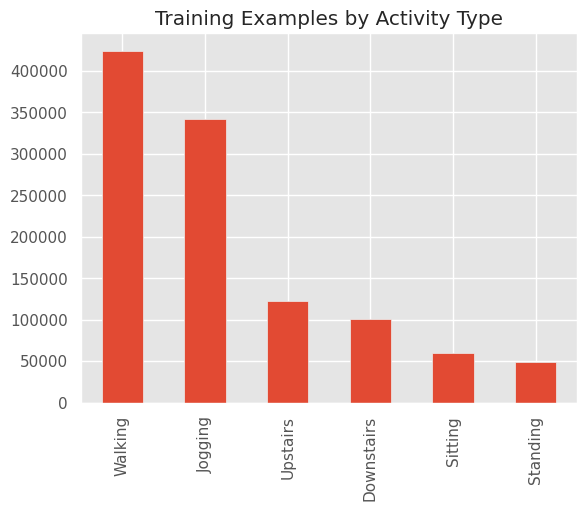

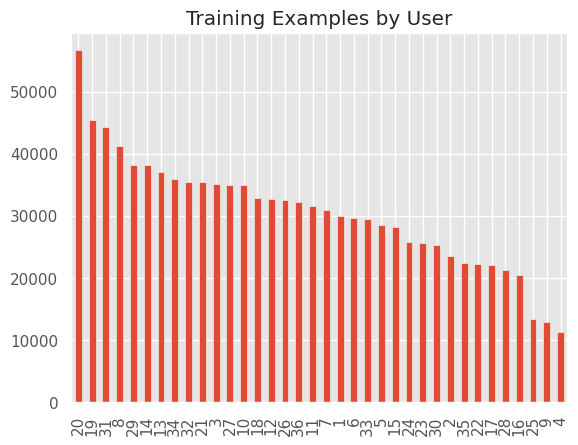

In [16]:
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

# by user
df['user'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

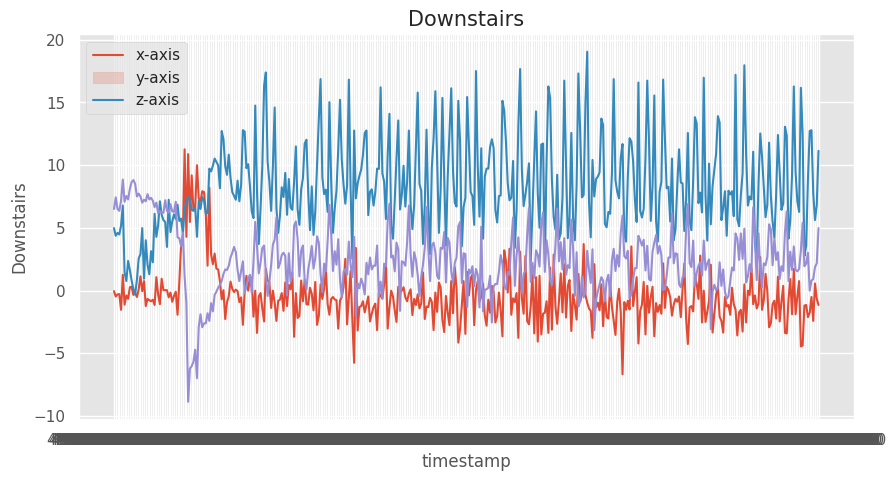

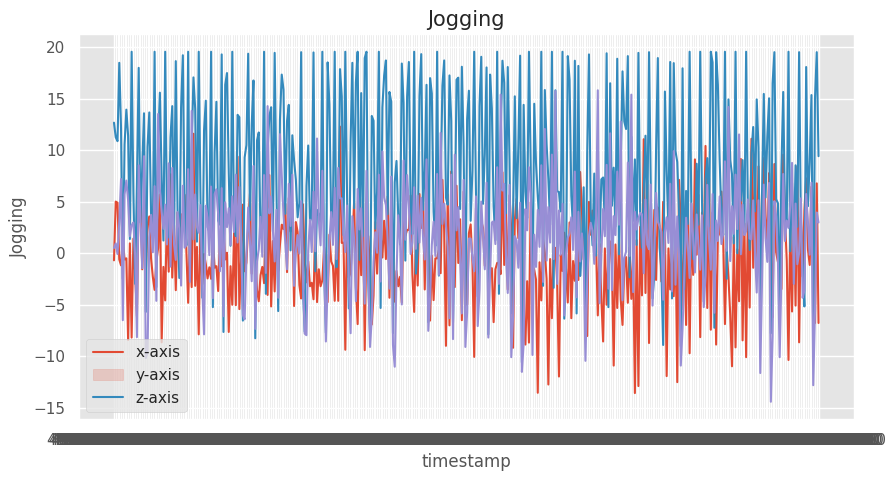

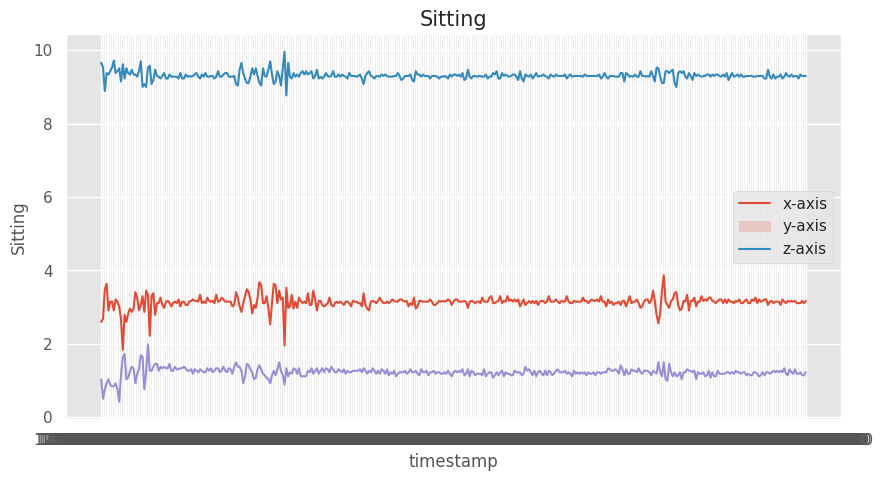

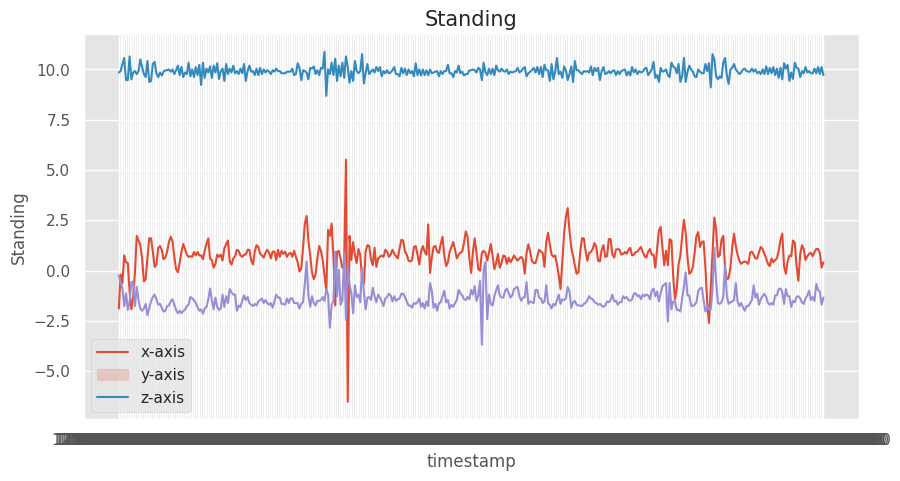

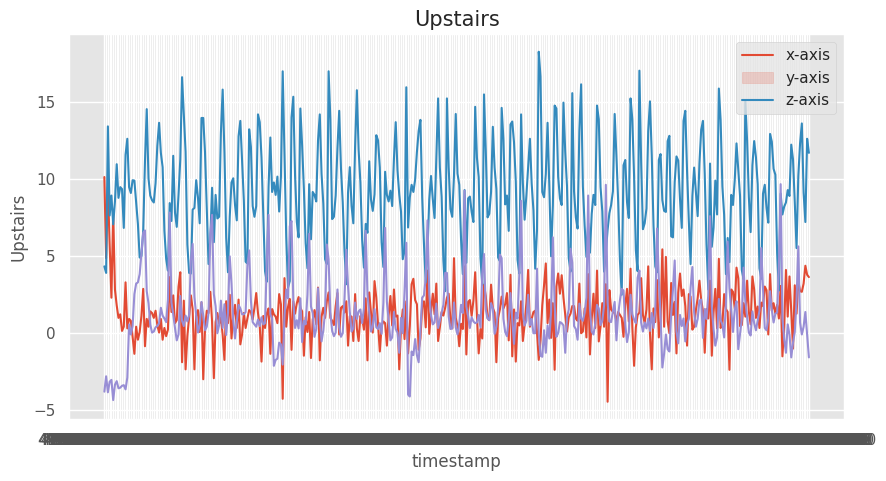

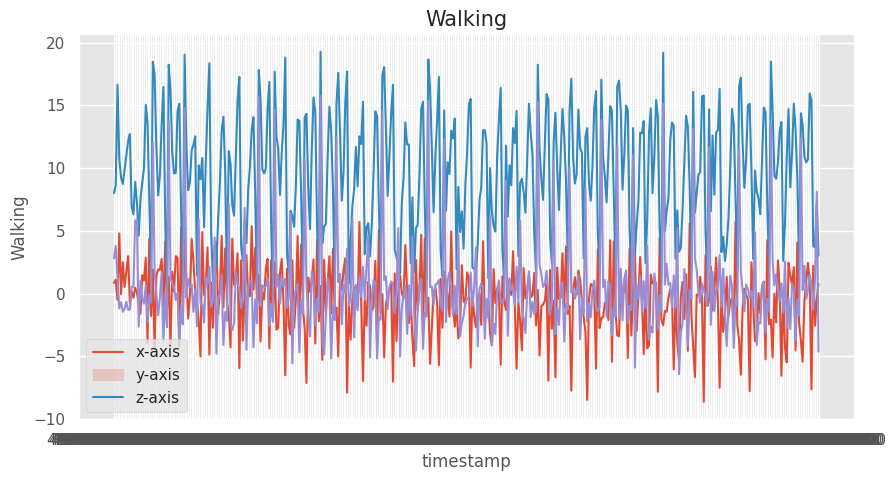

In [17]:
for i in np.unique(df['activity']):
    fig, ax = plt.subplots(figsize=(10,5))
    data36 = df[df['activity'] == i][:400]
    sns.lineplot(y = 'x-axis', x = 'timestamp', data = data36)
    sns.lineplot(y = 'y-axis', x = 'timestamp', data = data36)
    sns.lineplot(y = 'z-axis', x = 'timestamp', data = data36)
    plt.legend(['x-axis', 'y-axis','z-axis'])
    plt.ylabel(i)
    plt.title(i, fontsize = 15)
    plt.show()

In [18]:
LABEL = 'ActivityEncoded'

le = preprocessing.LabelEncoder()  # string to Integer
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.7,12.7,0.5,1
1,33,Jogging,49106062271000,5.0,11.3,1.0,1
2,33,Jogging,49106112167000,4.9,10.9,-0.1,1
3,33,Jogging,49106222305000,-0.6,18.5,3.0,1
4,33,Jogging,49106332290000,-1.2,12.1,7.2,1


In [40]:
df['user'] = df['user'].astype(int)
df['timestamp']=df['timestamp'].astype(int)


In [41]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.7,12.7,0.5,1
1,33,Jogging,49106062271000,5.0,11.3,1.0,1
2,33,Jogging,49106112167000,4.9,10.9,-0.1,1
3,33,Jogging,49106222305000,-0.6,18.5,3.0,1
4,33,Jogging,49106332290000,-1.2,12.1,7.2,1


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   user             1098203 non-null  int64  
 1   activity         1098203 non-null  object 
 2   timestamp        1098203 non-null  int64  
 3   x-axis           1098203 non-null  float64
 4   y-axis           1098203 non-null  float64
 5   z-axis           1098203 non-null  float64
 6   ActivityEncoded  1098203 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 67.0+ MB


In [43]:
print(set(df['user']))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36}


In [44]:
len(set(df['user']))

36

In [45]:
df.ActivityEncoded.tail(10)

1098194    2
1098195    2
1098196    2
1098197    2
1098198    2
1098199    2
1098200    2
1098201    2
1098202    2
1098203    2
Name: ActivityEncoded, dtype: int64

In [46]:
set(df.ActivityEncoded)

{0, 1, 2, 3, 4, 5}

In [47]:
random_seed = 42
n_time_steps = 50
n_features = 3
step = 10
n_classes = 6
n_epochs = 50
batch_size = 1024
learning_rate = 0.0025
l2_loss = 0.0015
segments = []
labels = []
for i in range(0,  df.shape[0]- n_time_steps, step):

    xs = df['x-axis'].values[i: i + 50]

    ys = df['y-axis'].values[i: i + 50]

    zs = df['z-axis'].values[i: i + 50]
    label, counts = np.unique(df['activity'][i: i + TIME_PERIODS], return_counts=True)
    label = label[counts.argmax()]
    label=label[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

In [48]:
np.array(segments).shape

(109816, 3, 50)

In [49]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)
labels = np.asarray(labels)
reshaped_segments.shape

(109816, 50, 3)

In [51]:
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
print(labels)
print(labels.shape)

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]
(109816, 5)


In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments,labels,test_size=0.2,random_state=41)

In [53]:
print('x_train shape: ', X_train.shape)
print(X_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (87852, 50, 3)
87852 training samples
y_train shape:  (87852, 5)


In [54]:
print('x_test shape: ', X_test.shape)
print(X_test.shape[0], 'testing samples')
print('y_test shape: ', y_test.shape)

x_test shape:  (21964, 50, 3)
21964 testing samples
y_test shape:  (21964, 5)


In [55]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               67584     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 76165 (297.52 KB)
Trainable params: 76165 (297.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
n_epochs = 50
batch_size = 1024
learning_rate = 0.0025
l2_loss = 0.0015
history = model.fit(X_train, y_train, epochs = n_epochs, validation_split = 0.20, batch_size = batch_size, verbose = 1)

Epoch 1/50
69/69 [==============================] - 11s 32ms/step - loss: 0.8455 - accuracy: 0.6933 - val_loss: 0.5439 - val_accuracy: 0.8077
Epoch 2/50
69/69 [==============================] - 1s 19ms/step - loss: 0.5008 - accuracy: 0.8216 - val_loss: 0.4599 - val_accuracy: 0.8334
Epoch 3/50
69/69 [==============================] - 1s 19ms/step - loss: 0.4423 - accuracy: 0.8391 - val_loss: 0.4534 - val_accuracy: 0.8327
Epoch 4/50
69/69 [==============================] - 1s 18ms/step - loss: 0.4103 - accuracy: 0.8470 - val_loss: 0.3963 - val_accuracy: 0.8508
Epoch 5/50
69/69 [==============================] - 1s 17ms/step - loss: 0.3716 - accuracy: 0.8610 - val_loss: 0.3454 - val_accuracy: 0.8712
Epoch 6/50
69/69 [==============================] - 1s 17ms/step - loss: 0.3349 - accuracy: 0.8745 - val_loss: 0.3340 - val_accuracy: 0.8772
Epoch 7/50
69/69 [==============================] - 1s 18ms/step - loss: 0.3106 - accuracy: 0.8841 - val_loss: 0.3099 - val_accuracy: 0.8879
Epoch 8/50
6

In [57]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)


22/22 [==============================] - 0s 10ms/step - loss: 0.1372 - accuracy: 0.9631
Test Accuracy : 0.9631214737892151
Test Loss : 0.13717666268348694


687/687 [==============================] - 3s 3ms/step


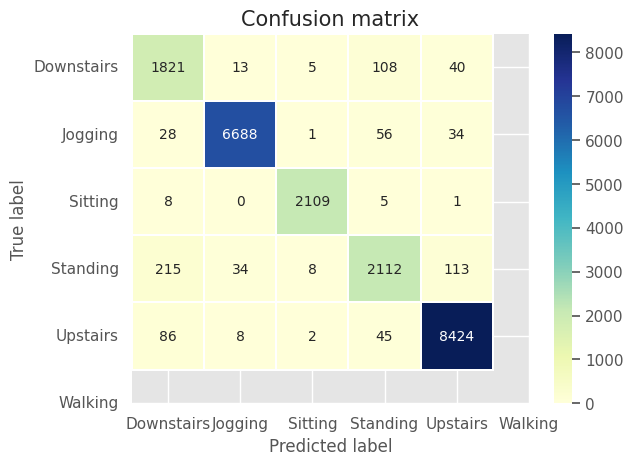

In [58]:
predictions = model.predict(X_test)
class_labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()